In [1]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.15.0
ipykernel        : 6.25.0
ipywidgets       : 8.0.4
jupyter_client   : 7.4.9
jupyter_core     : 5.3.0
jupyter_server   : 1.23.4
jupyterlab       : 3.6.3
nbclient         : 0.5.13
nbconvert        : 6.5.4
nbformat         : 5.9.2
notebook         : 6.5.4
qtconsole        : 5.4.2
traitlets        : 5.7.1


# Introduction

### What is Yu-Gi-Oh

### How dataset was obtained

### Motivation for data analysis, Problem Statement

Questions We Are Looking To Answer 
- Predict price of card (Linear Regressions) \[attk/level/defence/set\] 
- Predict level based on attack and defence 
- Predict "effect monster" Type \[categorical\] based (Classification Tree) 

Pointers <br>
Make a point on how data is cleaned 
Still do EDA, and see the exceptions 
AKA showcase you know your stuff 
Can split monsters based on can summon normally, or need sacrifice to find. 
 - Can become categorical (bucketing, similar to histograms) 
Show the trend of powercreep over the sets

In [2]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

In [3]:
data_file_location = 'card_data.csv'

yugioh_data = pd.read_csv(data_file_location,index_col=0)
yugioh_data.head(10) # quick look of data

,id,name,type,frameType,desc,race,archetype,card_sets,card_images,card_prices,atk,def,level,attribute,pend_desc,monster_desc,scale,linkval,linkmarkers,banlist_info
0,34541863,"""A"" Cell Breeding Device",Spell Card,spell,"During each of your Standby Phases, put 1 A-Co...",Continuous,Alien,"[{'set_name': 'Force of the Breaker', 'set_cod...","[{'id': 34541863, 'image_url': 'https://images...","[{'cardmarket_price': '0.10', 'tcgplayer_price...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,64163367,"""A"" Cell Incubator",Spell Card,spell,Each time an A-Counter(s) is removed from play...,Continuous,Alien,"[{'set_name': ""Gladiator's Assault"", 'set_code...","[{'id': 64163367, 'image_url': 'https://images...","[{'cardmarket_price': '0.07', 'tcgplayer_price...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,91231901,"""A"" Cell Recombination Device",Spell Card,spell,Target 1 face-up monster on the field; send 1 ...,Quick-Play,Alien,"[{'set_name': 'Invasion: Vengeance', 'set_code...","[{'id': 91231901, 'image_url': 'https://images...","[{'cardmarket_price': '0.10', 'tcgplayer_price...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,73262676,"""A"" Cell Scatter Burst",Spell Card,spell,"Select 1 face-up ""Alien"" monster you control. ...",Quick-Play,Alien,"[{'set_name': 'Strike of Neos', 'set_code': 'S...","[{'id': 73262676, 'image_url': 'https://images...","[{'cardmarket_price': '0.12', 'tcgplayer_price...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,98319530,"""Infernoble Arms - Almace""",Spell Card,spell,While this card is equipped to a monster: You ...,Equip,Noble Knight,"[{'set_name': 'Duelist Nexus', 'set_code': 'DU...","[{'id': 98319530, 'image_url': 'https://images...","[{'cardmarket_price': '0.00', 'tcgplayer_price...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,37478723,"""Infernoble Arms - Durendal""",Spell Card,spell,While this card is equipped to a monster: You ...,Equip,Noble Knight,"[{'set_name': '2021 Tin of Ancient Battles', '...","[{'id': 37478723, 'image_url': 'https://images...","[{'cardmarket_price': '0.16', 'tcgplayer_price...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,64867422,"""Infernoble Arms - Hauteclere""",Spell Card,spell,While this card is equipped to a monster: You ...,Equip,Noble Knight,"[{'set_name': '2021 Tin of Ancient Battles', '...","[{'id': 64867422, 'image_url': 'https://images...","[{'cardmarket_price': '0.02', 'tcgplayer_price...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,90861137,"""Infernoble Arms - Joyeuse""",Spell Card,spell,While this card is equipped to a monster: You ...,Equip,Noble Knight,"[{'set_name': '2021 Tin of Ancient Battles', '...","[{'id': 90861137, 'image_url': 'https://images...","[{'cardmarket_price': '0.18', 'tcgplayer_price...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,80845034,"""The Sinful Spoils Hunter Fiend""",Spell Card,spell,"Add 1 ""Diabellestarr"" monster from your Deck o...",Quick-Play,Sinful Spoils,NaN,"[{'id': 80845034, 'image_url': 'https://images...","[{'cardmarket_price': '0.00', 'tcgplayer_price...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,44256816,1st Movement Solo,Spell Card,spell,If you control no monsters: Special Summon 1 L...,Normal,Melodious,"[{'set_name': '2015 Mega-Tin Mega Pack', 'set_...","[{'id': 44256816, 'image_url': 'https://images...","[{'cardmarket_price': '2.85', 'tcgplayer_price...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
### Drop irrelevant columns about descriptions
yugioh_data = pd.read_csv(data_file_location,index_col=0)
yugioh_data = yugioh_data.drop(['desc','pend_desc','card_images','monster_desc','linkval','pend_desc','scale','linkmarkers'], axis=1)

### Extract price data into 5 columns from original column
import json
# Strip the starting and ending '[]' from column
yugioh_data['card_prices'] = yugioh_data['card_prices'].str.strip('[]')

# Convert the string in the 'card_prices' column to a dictionary
yugioh_data['card_prices'] = yugioh_data['card_prices'].apply(lambda x: json.loads(x.replace("'", '"')))

# Normalize the 'card_prices' column to create separate columns for each key in the dictionary
yugioh_data = pd.concat([yugioh_data, pd.json_normalize(yugioh_data['card_prices'])], axis=1)

# Prices are currently of type string, convert price_columns to float64
price_columns = ['cardmarket_price', 'tcgplayer_price', 'ebay_price', 'amazon_price', 'coolstuffinc_price']
yugioh_data[price_columns] = yugioh_data[price_columns].apply(pd.to_numeric)

# Now the DataFrame 'yugioh_data' contains 5 new columns with the prices from the 'card_prices' column as float64
#yugioh_data.head()

### Find the mean price, ignoring null values
# Set 0.00 price to NaN
yugioh_data[price_columns] = yugioh_data[price_columns].replace(0.00, np.NaN)
# Calculate mean price into ['avg_price']
yugioh_data['avg_price'] = yugioh_data[price_columns].mean(axis=1, skipna=True)
# Set Nan to 0.00 price 
yugioh_data[price_columns] = yugioh_data[price_columns].replace(np.NaN, 0.00)
# Dataframe displayed
price_columns.append("avg_price")
yugioh_data.head()


,id,name,type,frameType,race,archetype,card_sets,card_prices,atk,def,level,attribute,banlist_info,cardmarket_price,tcgplayer_price,ebay_price,amazon_price,coolstuffinc_price,avg_price
0,34541863,"""A"" Cell Breeding Device",Spell Card,spell,Continuous,Alien,"[{'set_name': 'Force of the Breaker', 'set_cod...","{'cardmarket_price': '0.10', 'tcgplayer_price'...",NaN,NaN,NaN,NaN,NaN,0.10,0.19,0.99,24.45,0.25,5.196
1,64163367,"""A"" Cell Incubator",Spell Card,spell,Continuous,Alien,"[{'set_name': ""Gladiator's Assault"", 'set_code...","{'cardmarket_price': '0.07', 'tcgplayer_price'...",NaN,NaN,NaN,NaN,NaN,0.07,0.24,1.25,0.50,0.25,0.462
2,91231901,"""A"" Cell Recombination Device",Spell Card,spell,Quick-Play,Alien,"[{'set_name': 'Invasion: Vengeance', 'set_code...","{'cardmarket_price': '0.10', 'tcgplayer_price'...",NaN,NaN,NaN,NaN,NaN,0.10,0.20,0.99,0.50,0.49,0.456
3,73262676,"""A"" Cell Scatter Burst",Spell Card,spell,Quick-Play,Alien,"[{'set_name': 'Strike of Neos', 'set_code': 'S...","{'cardmarket_price': '0.12', 'tcgplayer_price'...",NaN,NaN,NaN,NaN,NaN,0.12,0.10,2.00,9.76,0.25,2.446
4,98319530,"""Infernoble Arms - Almace""",Spell Card,spell,Equip,Noble Knight,"[{'set_name': 'Duelist Nexus', 'set_code': 'DU...","{'cardmarket_price': '0.00', 'tcgplayer_price'...",NaN,NaN,NaN,NaN,NaN,0.00,0.64,0.00,0.00,0.00,0.640


### Reduce skew of 'cardmarket_price'
#### Remove rows with outlier price value for CardMarket price
Remove prices above 100 Dollars <br>
Remove prices of 0 Dollars (not listed on cardmarket)

<Axes: >

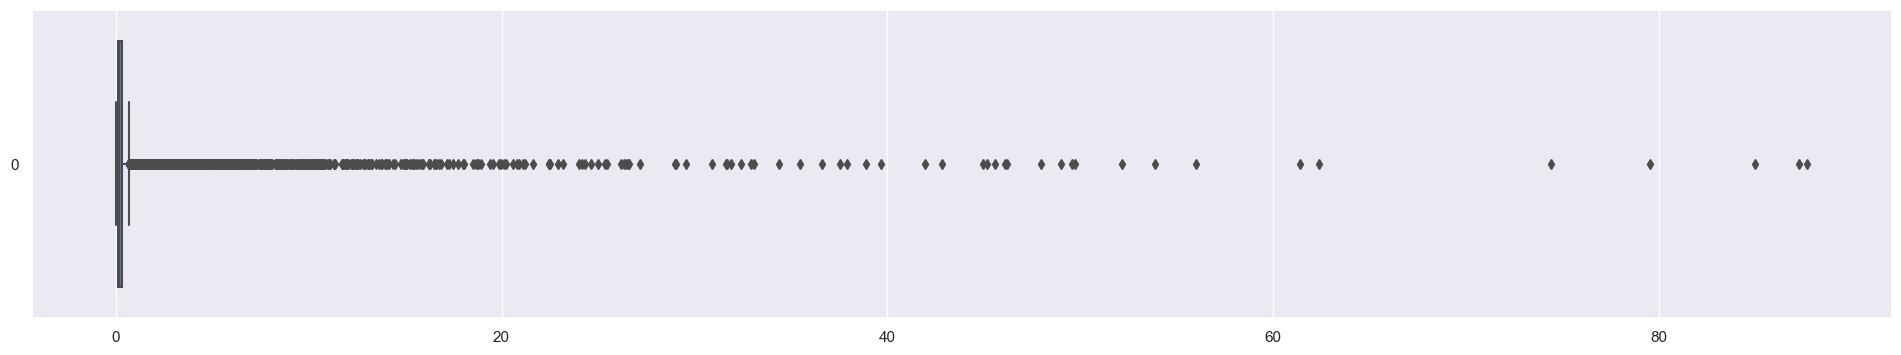

In [5]:
# Remove rows with prices that are missing or above 100.
yugioh_data = yugioh_data[(yugioh_data['cardmarket_price'] > 0.00) & (yugioh_data['cardmarket_price'] < 100)]
yugioh_data['cardmarket_price'].describe()

f = plt.figure(figsize=(24, 4))
sb.boxplot(data = yugioh_data['cardmarket_price'], orient = "h")

<Axes: >

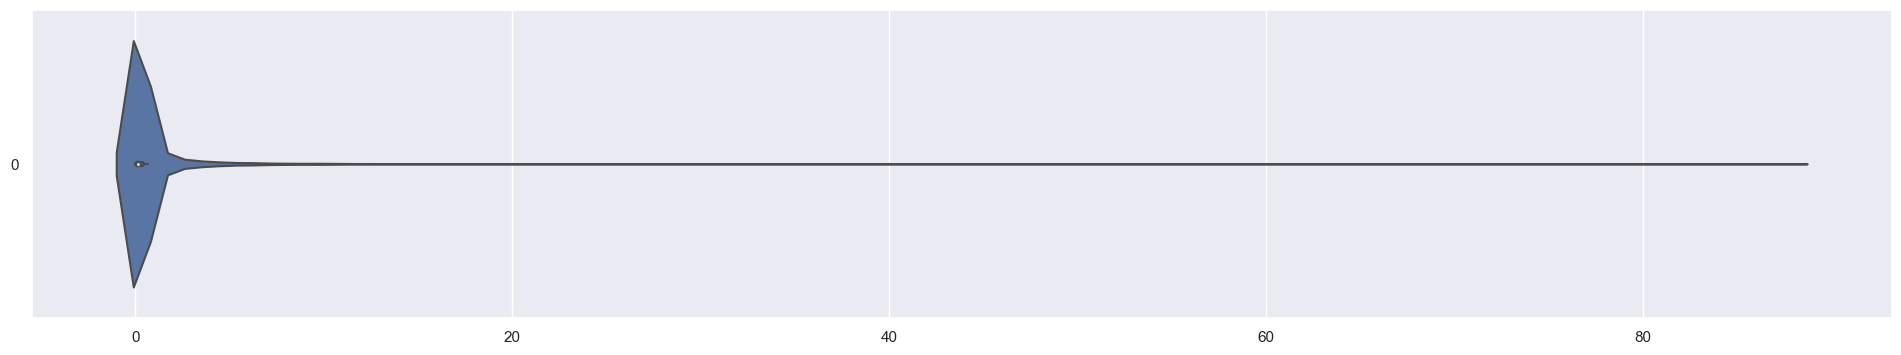

In [6]:
f = plt.figure(figsize=(24, 4))
sb.violinplot(data = yugioh_data['cardmarket_price'], orient = "h")

<Axes: >

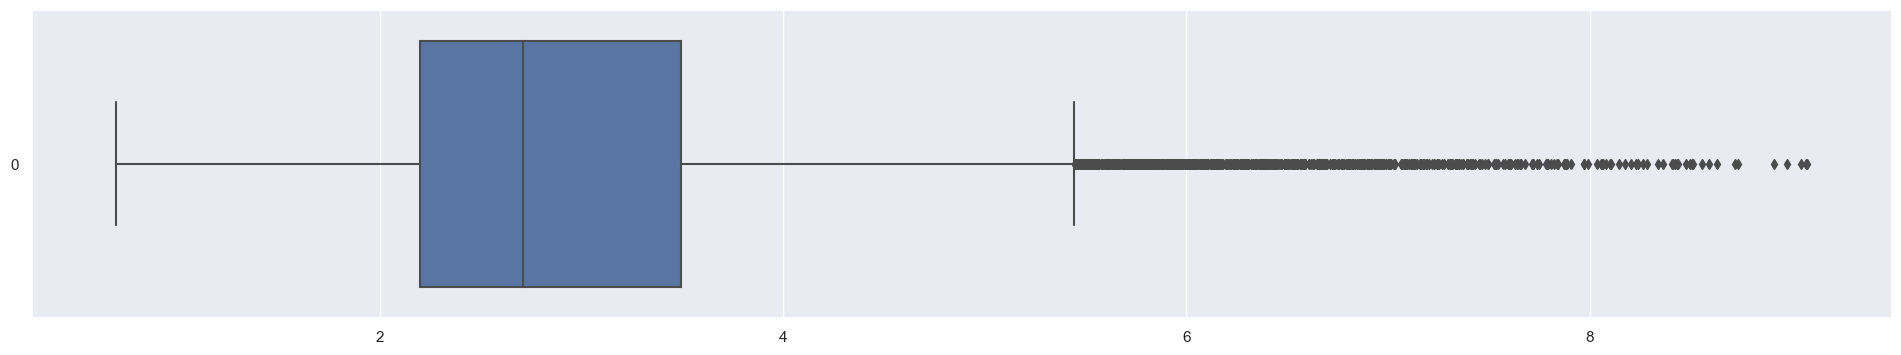

In [7]:
### 2 Methods to prepare data for Logarithm
# Increment values by 1
#yugioh_data["cardmarket_price"] = yugioh_data["cardmarket_price"] + 1
#yugioh_data['cardmarket_price'].describe()

# Convert data to integer values by * 100
yugioh_data["cardmarket_price"] = yugioh_data["cardmarket_price"] * 100
yugioh_data['cardmarket_price'].describe()


yugioh_data['cardmarket_price'] = np.log(yugioh_data["cardmarket_price"]) #Apply a logarithmic transformation to the data

f = plt.figure(figsize=(24, 4))
sb.boxplot(data = yugioh_data['cardmarket_price'], orient = "h")


<Axes: >

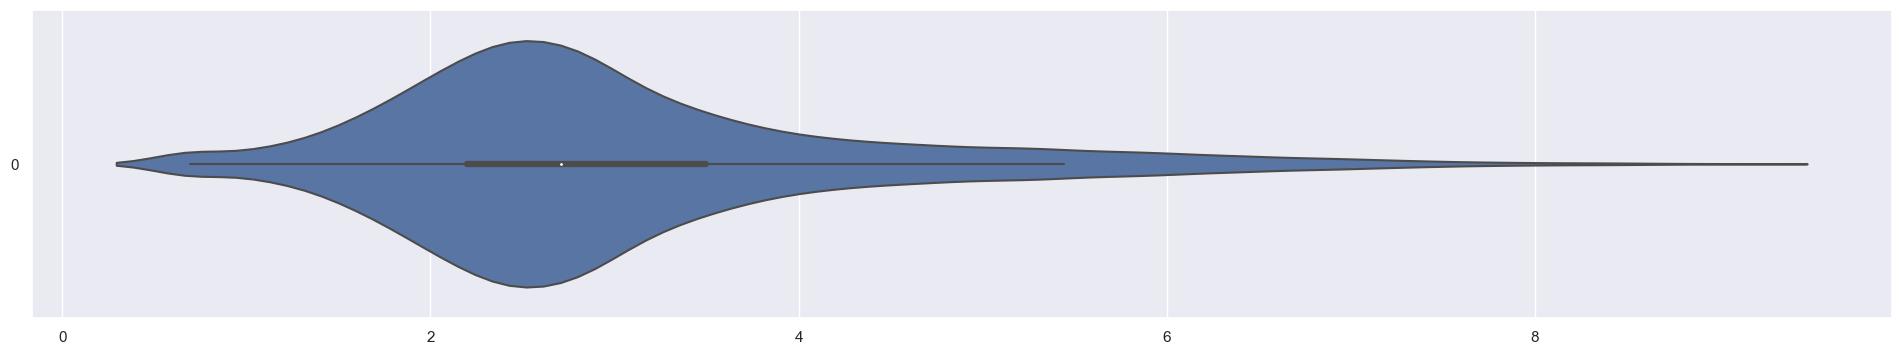

In [8]:
f = plt.figure(figsize=(24, 4))
sb.violinplot(data = yugioh_data['cardmarket_price'], orient = "h")

<Axes: >

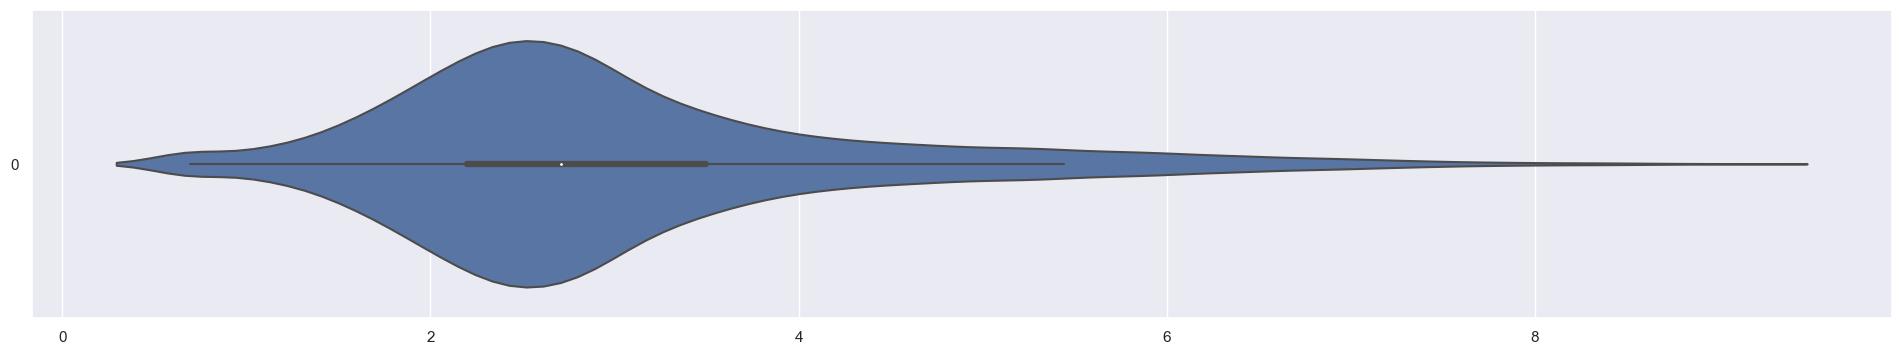

In [9]:
f = plt.figure(figsize=(24, 4))
sb.violinplot(data = yugioh_data['cardmarket_price'], orient = "h")

In [10]:
#cardmarket_price = pd.DataFrame(yugioh_data["cardmarket_price"])
#cardmarket_price = cardmarket_price[cardmarket_price > 0.0 & cardmarket_price < 100.0]
#cardmarket_price.head()

#### Separate "Level" into level ranges and bins 

In [11]:
# Define the bins for the level ranges
bins = [1.0, 4.0, 6.0, float('inf')]

# Define the labels for the level ranges
labels = ['0', '1', '2']

# Create a new column 'level_group' to store the bucketed groups
yugioh_data['tribute'] = pd.cut(yugioh_data['level'], bins=bins, labels=labels, right=False)

tribute0 = yugioh_data[yugioh_data['level'].between(1, 4)]
tribute1 = yugioh_data[yugioh_data['level'].between(5, 6)]
tribute2 = yugioh_data[yugioh_data['level'] >= 7]

# Now the DataFrame 'df' contains a new column 'level_group' with the cards bucketed into the specified level ranges
yugioh_data.head()

,id,name,type,frameType,race,archetype,card_sets,card_prices,atk,def,level,attribute,banlist_info,cardmarket_price,tcgplayer_price,ebay_price,amazon_price,coolstuffinc_price,avg_price,tribute
0,34541863,"""A"" Cell Breeding Device",Spell Card,spell,Continuous,Alien,"[{'set_name': 'Force of the Breaker', 'set_cod...","{'cardmarket_price': '0.10', 'tcgplayer_price'...",NaN,NaN,NaN,NaN,NaN,2.302585,0.19,0.99,24.45,0.25,5.1960,NaN
1,64163367,"""A"" Cell Incubator",Spell Card,spell,Continuous,Alien,"[{'set_name': ""Gladiator's Assault"", 'set_code...","{'cardmarket_price': '0.07', 'tcgplayer_price'...",NaN,NaN,NaN,NaN,NaN,1.945910,0.24,1.25,0.50,0.25,0.4620,NaN
2,91231901,"""A"" Cell Recombination Device",Spell Card,spell,Quick-Play,Alien,"[{'set_name': 'Invasion: Vengeance', 'set_code...","{'cardmarket_price': '0.10', 'tcgplayer_price'...",NaN,NaN,NaN,NaN,NaN,2.302585,0.20,0.99,0.50,0.49,0.4560,NaN
3,73262676,"""A"" Cell Scatter Burst",Spell Card,spell,Quick-Play,Alien,"[{'set_name': 'Strike of Neos', 'set_code': 'S...","{'cardmarket_price': '0.12', 'tcgplayer_price'...",NaN,NaN,NaN,NaN,NaN,2.484907,0.10,2.00,9.76,0.25,2.4460,NaN
5,37478723,"""Infernoble Arms - Durendal""",Spell Card,spell,Equip,Noble Knight,"[{'set_name': '2021 Tin of Ancient Battles', '...","{'cardmarket_price': '0.16', 'tcgplayer_price'...",NaN,NaN,NaN,NaN,NaN,2.772589,0.12,0.99,2.96,0.00,1.0575,NaN


# Exploratory Data Analysis [EDA]

In [12]:
# Information about the Variables
yugioh_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12241 entries, 0 to 12814
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   id                  12241 non-null  int64   
 1   name                12241 non-null  object  
 2   type                12241 non-null  object  
 3   frameType           12241 non-null  object  
 4   race                12241 non-null  object  
 5   archetype           7217 non-null   object  
 6   card_sets           12223 non-null  object  
 7   card_prices         12241 non-null  object  
 8   atk                 7918 non-null   float64 
 9   def                 7542 non-null   float64 
 10  level               7542 non-null   float64 
 11  attribute           7918 non-null   object  
 12  banlist_info        288 non-null    object  
 13  cardmarket_price    12241 non-null  float64 
 14  tcgplayer_price     12241 non-null  float64 
 15  ebay_price          12241 non-null  float

<b> Listing down observations of dataset: </b>

- 20 columns and 12815 rows.
- 1 variables identified as int64 by default, and it seems is indeed Numeric.
- 5 variables identified as float64 by default, and it seems are indeed Numeric.
- 14 variables identified as object by default, 
    - 4 variables are Strings, which represent card text and should not be used for Categorical values.
        - (name, desc, pend_desc, monster_desc)
    - 1 variables is a JSON object, which represent link data to card images and should not be used for Categorical values.
        - (card_images)
    - 3 variables are JSON objects, which represent Categorical values.
        - (card_sets, linkmarkers, banlist_info)
    - 5 variables are Strings, which represent Categorical values.
        - (type, frameType, race, archetype, attribute)
    - 1 variables is a JSON object, which represent multiple Numeric values.
        - (card_prices)


<b> Cleaning actions to be taken </b> <br>
    - Extract out values from relevant JSON objects (card_prices)
    
None of the variables/features seem to have any missing value (have to check again, carefully).
- card_prices is 


### Data Cleaning


In [13]:
# Drop card text about descriptions
#yugioh_data = yugioh_data.drop(['desc', 'pend_desc', 'monster_desc'], axis=1)
#yugioh_data.head()

In [14]:
# Visulising unique types for categorical values
unique_types = yugioh_data['type'].unique()
print(unique_types)

['Spell Card' 'Effect Monster' 'Flip Effect Monster' 'Normal Monster'
 'Trap Card' 'Union Effect Monster' 'Fusion Monster'
 'Pendulum Effect Monster' 'Link Monster' 'XYZ Monster' 'Synchro Monster'
 'Synchro Tuner Monster' 'Tuner Monster' 'Gemini Monster'
 'Normal Tuner Monster' 'Spirit Monster' 'Ritual Effect Monster' 'Token'
 'Pendulum Effect Fusion Monster' 'Skill Card' 'Ritual Monster'
 'Toon Monster' 'Pendulum Normal Monster'
 'Synchro Pendulum Effect Monster' 'Pendulum Tuner Effect Monster'
 'XYZ Pendulum Effect Monster' 'Pendulum Effect Ritual Monster'
 'Pendulum Flip Effect Monster']


In [15]:
# Remove non-monsters from dataset.
yugioh_data = yugioh_data[~yugioh_data['type'].isin(['Skill Card', 'Spell Card', 'Trap Card', 'Token'])]
yugioh_data.head()

,id,name,type,frameType,race,archetype,card_sets,card_prices,atk,def,level,attribute,banlist_info,cardmarket_price,tcgplayer_price,ebay_price,amazon_price,coolstuffinc_price,avg_price,tribute
10,86988864,3-Hump Lacooda,Effect Monster,effect,Beast,NaN,"[{'set_name': 'Ancient Sanctuary', 'set_code':...","{'cardmarket_price': '0.16', 'tcgplayer_price'...",500.0,1500.0,3.0,EARTH,NaN,2.772589,0.16,1.00,0.25,0.25,0.364,0
12,83994646,4-Starred Ladybug of Doom,Flip Effect Monster,effect,Insect,NaN,"[{'set_name': 'Dark Beginning 1', 'set_code': ...","{'cardmarket_price': '0.12', 'tcgplayer_price'...",800.0,1200.0,3.0,WIND,NaN,2.484907,0.05,0.99,0.99,0.25,0.480,0
14,23771716,7 Colored Fish,Normal Monster,normal,Fish,NaN,"[{'set_name': 'Gold Series', 'set_code': 'GLD1...","{'cardmarket_price': '0.06', 'tcgplayer_price'...",1800.0,800.0,4.0,WATER,NaN,1.791759,0.16,1.99,2.77,0.39,1.074,1
16,14261867,8-Claws Scorpion,Effect Monster,effect,Insect,NaN,"[{'set_name': 'Gold Series', 'set_code': 'GLD1...","{'cardmarket_price': '0.11', 'tcgplayer_price'...",300.0,200.0,2.0,DARK,NaN,2.397895,0.22,0.99,0.20,0.25,0.354,0
17,24140059,A Cat of Ill Omen,Flip Effect Monster,effect,Beast,NaN,"[{'set_name': 'Dark Revelation Volume 1', 'set...","{'cardmarket_price': '0.69', 'tcgplayer_price'...",500.0,300.0,2.0,DARK,NaN,4.234107,1.76,3.99,4.49,0.99,2.384,0


# EDA OF NUMERIC VALUES


### Generating Additional Numerical Columns

In [16]:
# Generate New Numerical Columns
yugioh_data['atk+def'] = yugioh_data.loc[:,['atk','def']].sum(axis=1)
yugioh_data['atkSq'] = yugioh_data['atk'] * yugioh_data['atk']
yugioh_data['defSq'] = yugioh_data['def'] * yugioh_data['def']
yugioh_data['atkSq+defSq'] = yugioh_data['atkSq'] + yugioh_data['defSq']

# Get an idea of current columns
price_columns = ['cardmarket_price', 'tcgplayer_price', 'ebay_price', 'amazon_price', 'coolstuffinc_price', 'avg_price']
numericalColumns = ['atk', 'def', 'level']
newNumericalColumns = ['atk+def', 'atkSq', 'defSq', 'atkSq+defSq']

numericalColumns.extend(price_columns)
numericalColumns.extend(newNumericalColumns)

yugioh_data.describe().round(2)

,id,atk,def,level,cardmarket_price,tcgplayer_price,ebay_price,amazon_price,coolstuffinc_price,avg_price,atk+def,atkSq,defSq,atkSq+defSq
count,7.889000e+03,7889.00,7513.00,7513.00,7889.00,7889.00,7889.00,7889.00,7889.00,7889.00,7889.00,7889.00,7513.00,7513.00
mean,4.942221e+07,1495.76,1260.44,4.61,3.12,1.09,4.40,4.29,1.34,2.50,2696.13,3125264.01,2336427.53,5438863.01
std,2.927285e+07,942.38,864.76,2.37,1.36,15.72,27.51,23.17,8.09,11.52,1546.08,3185682.02,2650192.16,5164160.22
min,2.511000e+03,0.00,0.00,0.00,0.69,0.00,0.00,0.00,0.00,0.11,0.00,0.00,0.00,0.00
25%,2.417523e+07,800.00,600.00,3.00,2.20,0.13,0.99,0.25,0.25,0.46,1700.00,640000.00,360000.00,2000000.00
50%,4.908891e+07,1500.00,1200.00,4.00,2.83,0.21,1.48,0.99,0.49,0.78,2600.00,2250000.00,1440000.00,4010000.00
75%,7.429468e+07,2200.00,1900.00,6.00,3.69,0.46,2.99,2.30,0.99,1.75,3600.00,4840000.00,3610000.00,7690000.00
max,5.010000e+08,5000.00,5000.00,13.00,9.08,999.99,999.99,999.99,499.99,515.65,10000.00,25000000.00,25000000.00,50000000.00


In [17]:
# Extract numeric data variables
yugioh_numerical_data = pd.DataFrame(yugioh_data[numericalColumns])

# Summary Statistics for all Variables
yugioh_numerical_data.describe().round(2)

KeyError: "['scale', 'linkval'] not in index"

KeyError: 0

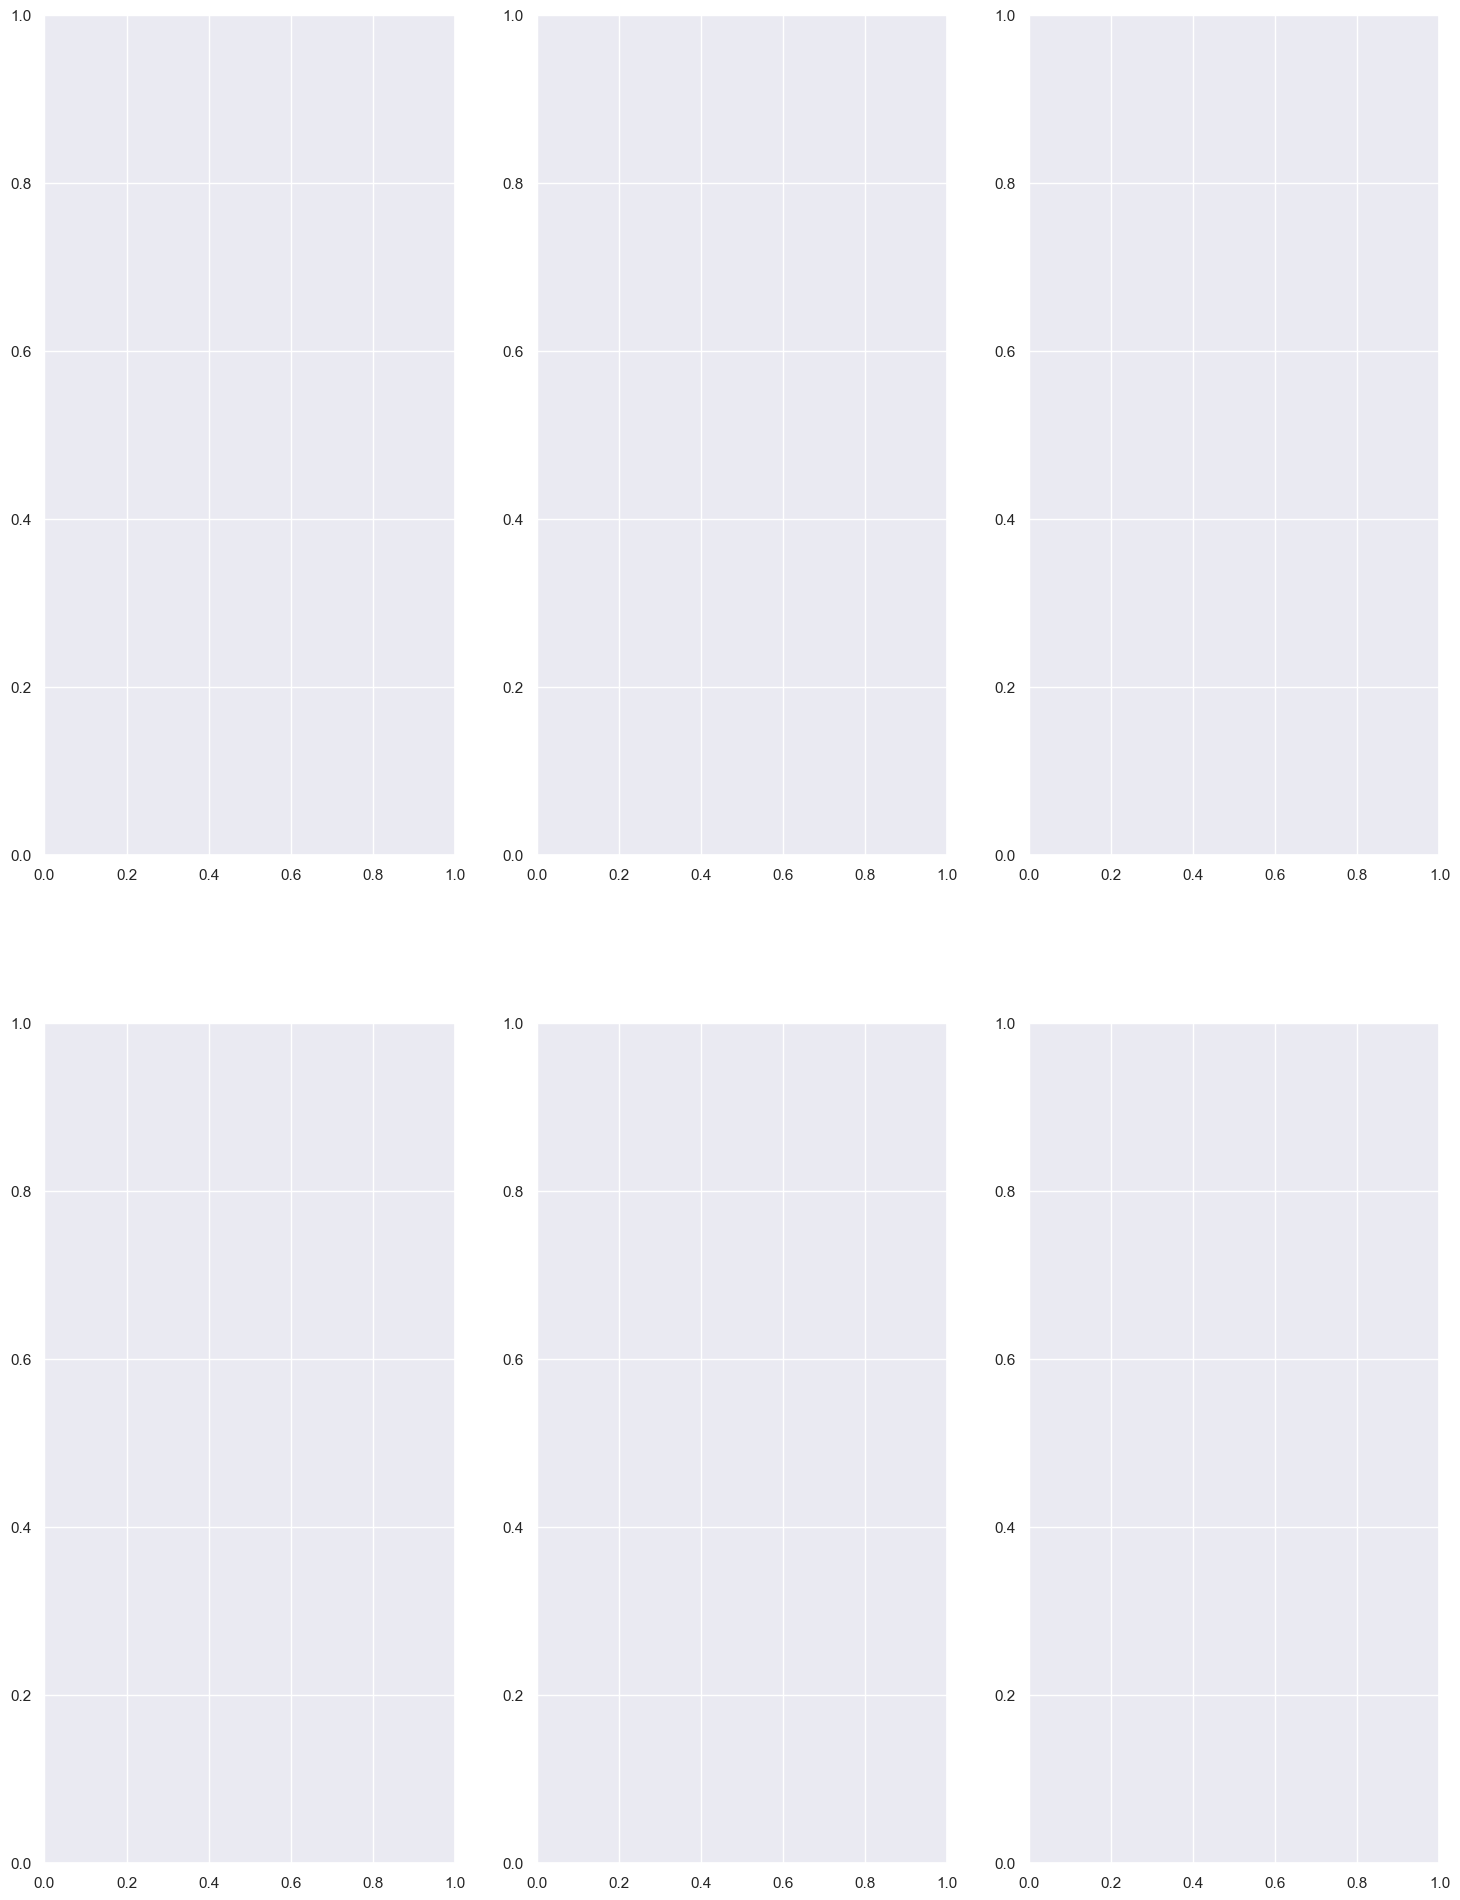

In [18]:
# Draw the distributions of all variables len(numericalColumns)
f, axes = plt.subplots(2, 3, figsize=(18, 24))

#yugioh_numerical_data = yugioh_numerical_data.reset_index(drop=True)

count = 0
for var in yugioh_numerical_data:
    sb.boxplot(data = yugioh_numerical_data[var], orient = "h", ax = axes[count,0])
    sb.histplot(data = yugioh_numerical_data[var], ax = axes[count,1])
    sb.violinplot(data = yugioh_numerical_data[var], orient = "h", ax = axes[count,2])
    count += 1

### Correlation Matrix of Numerical Variables

<Axes: >

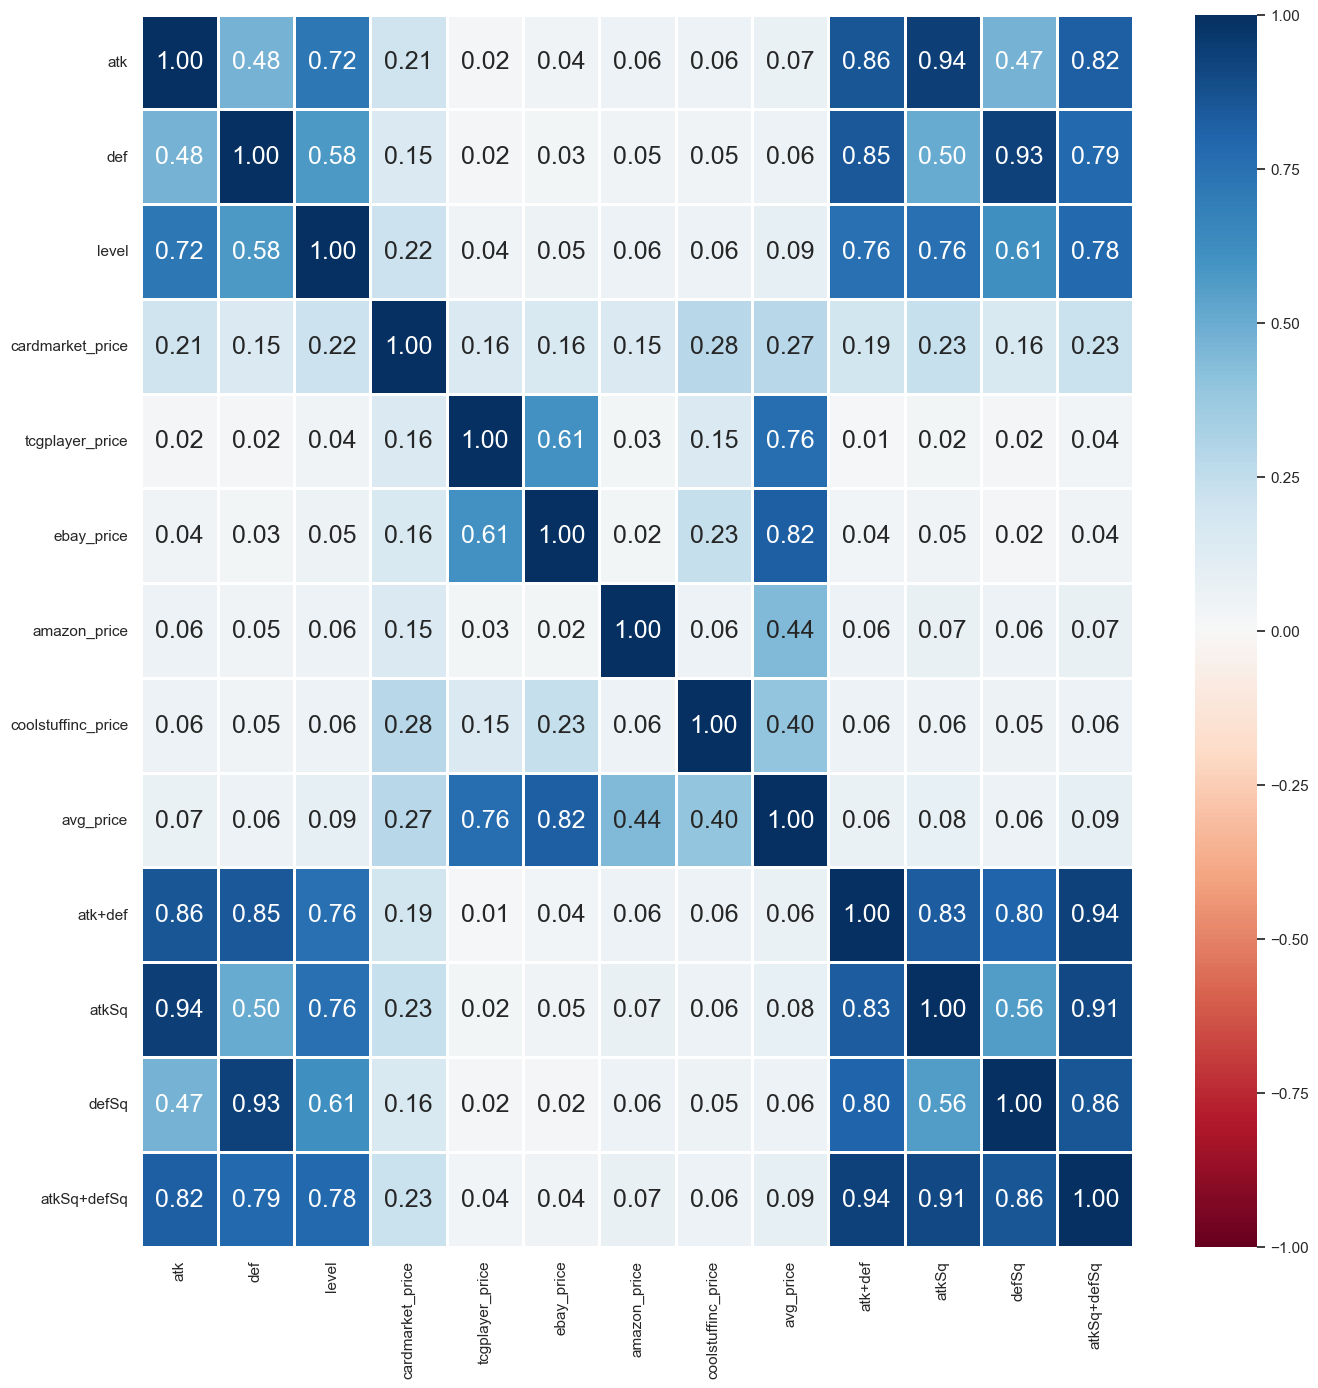

In [19]:
# Correlation Matrix
#print(yugioh_numerical_data.corr())

# Heatmap of the Correlation Matrix
f = plt.figure(figsize=(16, 16))
sb.heatmap(yugioh_numerical_data.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")

### Realisation for linear regression / Analysis of correlation matrix
Despite measures taken to 

In [22]:
yugioh_numerical_data.head()

,atk,def,level,cardmarket_price,tcgplayer_price,ebay_price,amazon_price,coolstuffinc_price,avg_price,atk+def,atkSq,defSq,atkSq+defSq
10,500.0,1500.0,3.0,2.772589,0.16,1.00,0.25,0.25,0.364,2000.0,250000.0,2250000.0,2500000.0
12,800.0,1200.0,3.0,2.484907,0.05,0.99,0.99,0.25,0.480,2000.0,640000.0,1440000.0,2080000.0
14,1800.0,800.0,4.0,1.791759,0.16,1.99,2.77,0.39,1.074,2600.0,3240000.0,640000.0,3880000.0
16,300.0,200.0,2.0,2.397895,0.22,0.99,0.20,0.25,0.354,500.0,90000.0,40000.0,130000.0
17,500.0,300.0,2.0,4.234107,1.76,3.99,4.49,0.99,2.384,800.0,250000.0,90000.0,340000.0


In [25]:
yugioh_data.head()

,id,name,type,frameType,race,archetype,card_sets,card_prices,atk,def,...,tcgplayer_price,ebay_price,amazon_price,coolstuffinc_price,avg_price,tribute,atk+def,atkSq,defSq,atkSq+defSq
10,86988864,3-Hump Lacooda,Effect Monster,effect,Beast,NaN,"[{'set_name': 'Ancient Sanctuary', 'set_code':...","{'cardmarket_price': '0.16', 'tcgplayer_price'...",500.0,1500.0,...,0.16,1.00,0.25,0.25,0.364,0,2000.0,250000.0,2250000.0,2500000.0
12,83994646,4-Starred Ladybug of Doom,Flip Effect Monster,effect,Insect,NaN,"[{'set_name': 'Dark Beginning 1', 'set_code': ...","{'cardmarket_price': '0.12', 'tcgplayer_price'...",800.0,1200.0,...,0.05,0.99,0.99,0.25,0.480,0,2000.0,640000.0,1440000.0,2080000.0
14,23771716,7 Colored Fish,Normal Monster,normal,Fish,NaN,"[{'set_name': 'Gold Series', 'set_code': 'GLD1...","{'cardmarket_price': '0.06', 'tcgplayer_price'...",1800.0,800.0,...,0.16,1.99,2.77,0.39,1.074,1,2600.0,3240000.0,640000.0,3880000.0
16,14261867,8-Claws Scorpion,Effect Monster,effect,Insect,NaN,"[{'set_name': 'Gold Series', 'set_code': 'GLD1...","{'cardmarket_price': '0.11', 'tcgplayer_price'...",300.0,200.0,...,0.22,0.99,0.20,0.25,0.354,0,500.0,90000.0,40000.0,130000.0
17,24140059,A Cat of Ill Omen,Flip Effect Monster,effect,Beast,NaN,"[{'set_name': 'Dark Revelation Volume 1', 'set...","{'cardmarket_price': '0.69', 'tcgplayer_price'...",500.0,300.0,...,1.76,3.99,4.49,0.99,2.384,0,800.0,250000.0,90000.0,340000.0


In [32]:
#yugioh_data_normalMonsters = yugioh_data[yugioh_data['type'].isin(['Normal Monster'])]

# Extract numeric data variables
#yugioh_numerical_data = pd.DataFrame(yugioh_data[numericalColumns])

yugioh_numerical_data_normalMonsters = yugioh_data.loc[yugioh_data['type'] == "Synchro Monster", numericalColumns]


#yugioh_data_effectMonsters = yugioh_data[yugioh_data['type'].isin(['Effect Monster'])]

yugioh_numerical_data_effectMonsters = yugioh_data.loc[yugioh_data['type'] == "Pendulum Effect Monster", numericalColumns]

<Axes: >

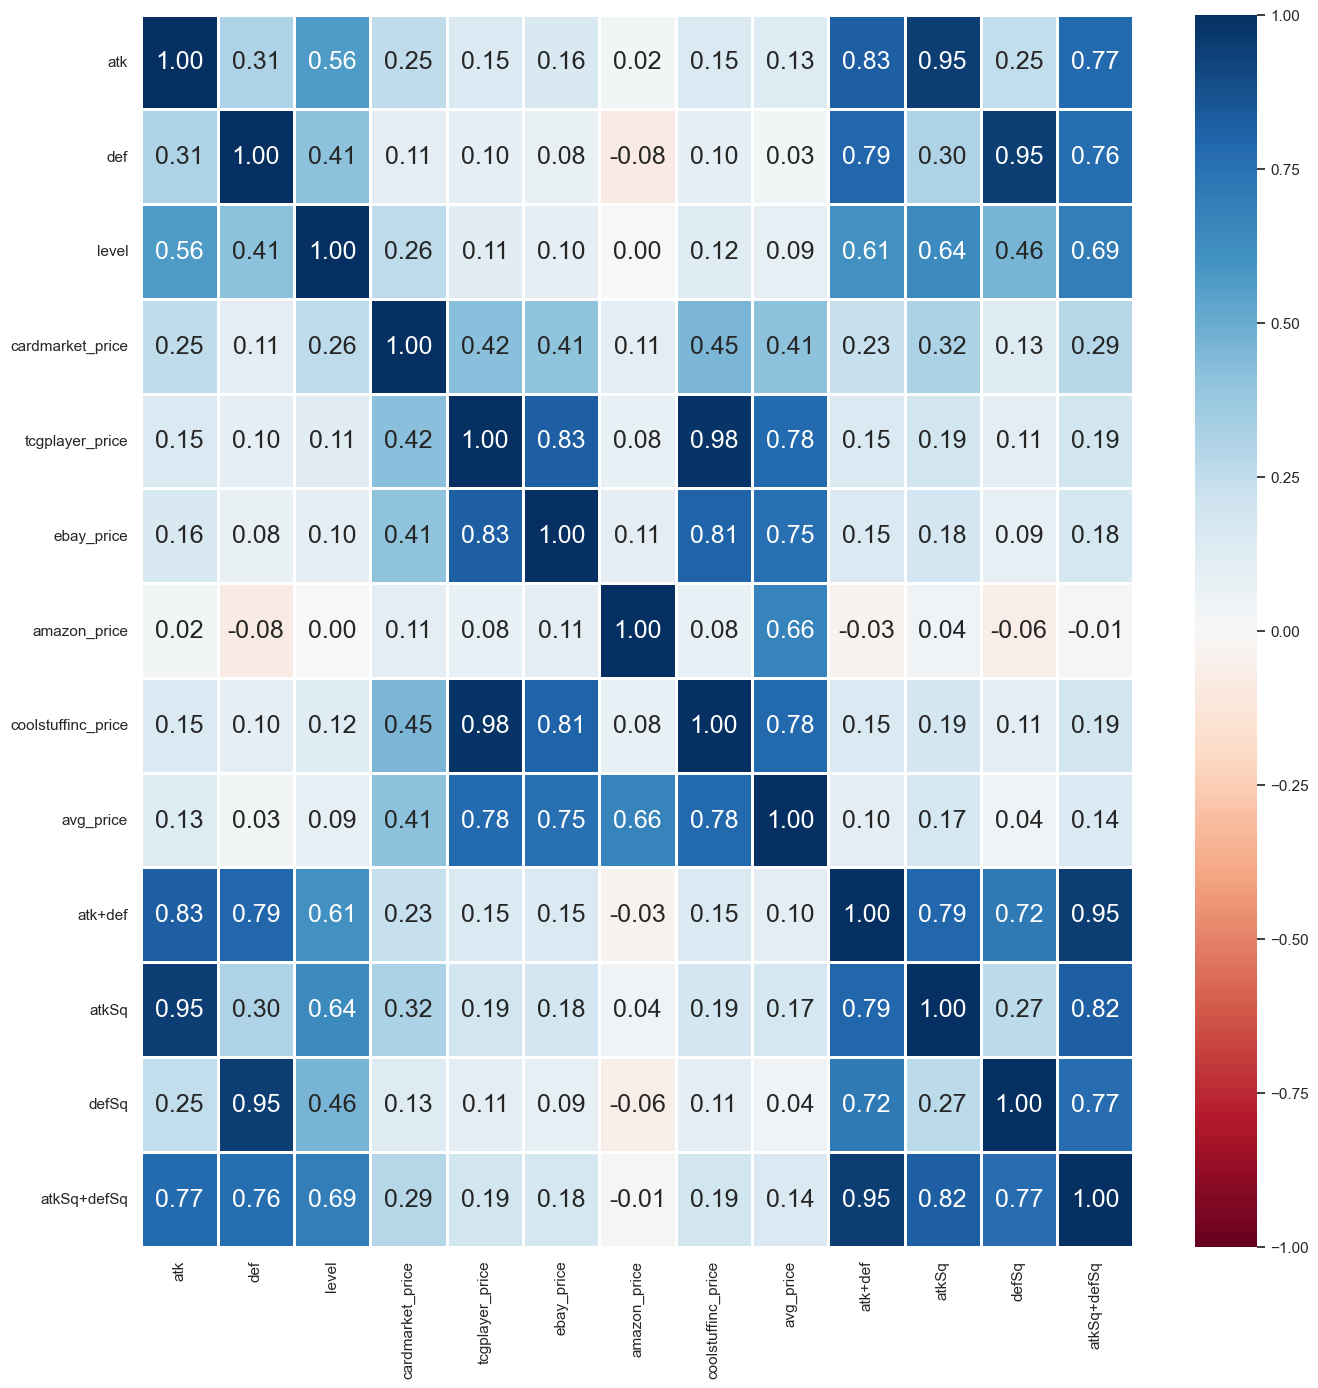

In [33]:
# Correlation Matrix
#print(yugioh_numerical_data.corr())

#yugioh_numerical_data_effectMonsters = yugioh_numerical_data[]

# Heatmap of the Correlation Matrix
f = plt.figure(figsize=(16, 16))
sb.heatmap(yugioh_numerical_data_effectMonsters.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")

<Axes: >

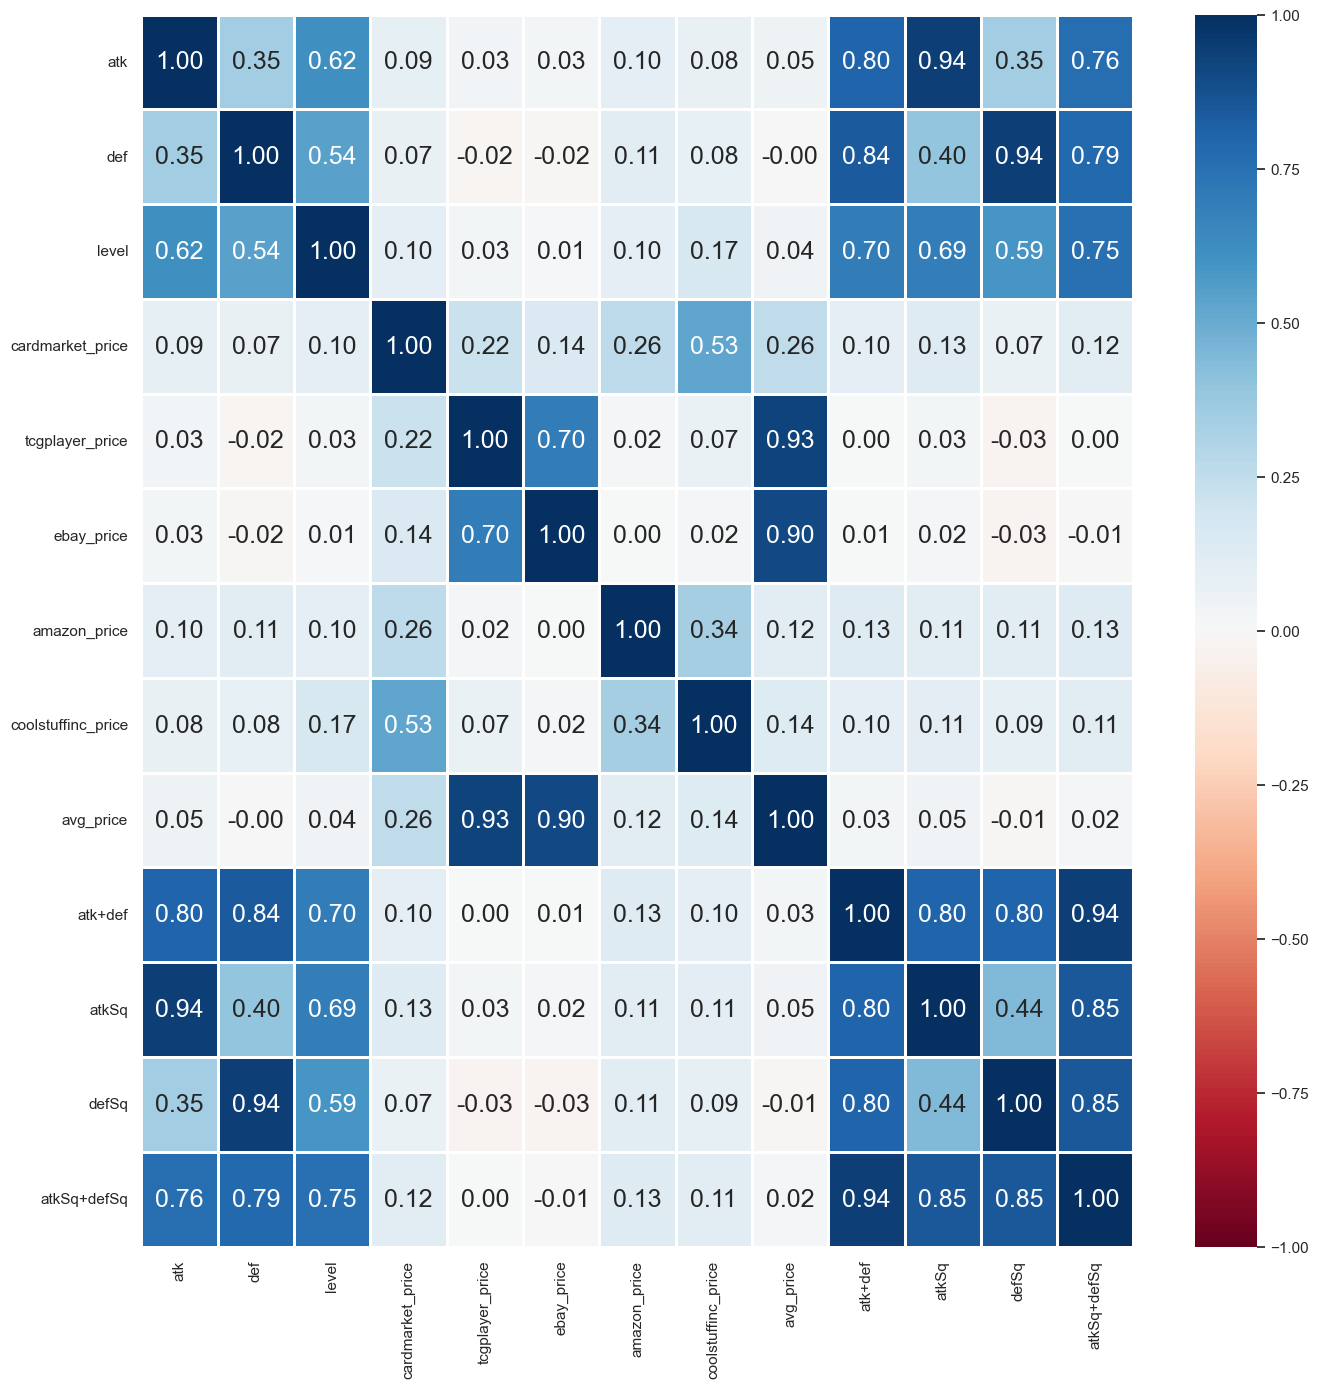

In [34]:
# Correlation Matrix
#print(yugioh_numerical_data.corr())

#yugioh_numerical_data_normalMonsters = yugioh_numerical_data[]

# Heatmap of the Correlation Matrix
f = plt.figure(figsize=(16, 16))
sb.heatmap(yugioh_numerical_data_normalMonsters.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")

# Linear Regresstion of Numerical Values

In [21]:
# Import essential models and functions from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Extract Response and Predictors
predictors = ["atk", "def", "level"]
reponse_variable = ["card_prices"]

y = pd.DataFrame(yugioh_data[reponse_variable])
X = pd.DataFrame(yugioh_data[predictors])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Print the Coefficients against Predictors
print(pd.DataFrame(list(zip(X_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"]))
print()

# Predict Response corresponding to Predictors
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Plot the training data and regression line.
f = plt.figure(figsize=(16, 8))
plt.scatter(X_train, y_train, color = "green")
#plt.scatter(X_test, y_test_pred, color = "red")
plt.axline((0, linreg.intercept_.item()), slope=linreg.coef_.item(), label='by slope', linewidth=4, color='r')
plt.show()

# Plot the test data and regression line.
f = plt.figure(figsize=(16, 8))
plt.scatter(X_test, y_test, color = "green")
#plt.scatter(X_test, y_test_pred, color = "red")
plt.axline((0, linreg.intercept_.item()), slope=linreg.coef_.item(), label='by slope', linewidth=4, color='r')
plt.show()

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### Conclusion of linear regression


In [ ]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Prediction Accuracy (on Test Data)
print("Prediction Accuracy      \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

# EDA OF CATEGORICAL VALUES
Using the following variables to predict `cardmarket_price`: `level`, `archetype`, `race`, `attribute`, `type`


In [18]:
categories = ['level','tribute','archetype','race','attribute','type','frameType','cardmarket_price']
#ugioh_data_categorical = yugioh_data[categories]
yugioh_data_categorical = tribute0[categories]
yugioh_data_categorical = yugioh_data_categorical[(yugioh_data_categorical['frameType'] == "normal")]

for var in categories[:-1]:
    print(yugioh_data_categorical[var].value_counts())
    #print("Number of categories: ", yugioh_data_categorical[var].value_counts().count())
    print()

level
4.0    213
3.0     97
2.0     50
1.0     27
Name: count, dtype: int64

tribute
1    213
0    174
2      0
Name: count, dtype: int64

archetype
Dark World         5
Exodia             4
Gem-               4
Elemental HERO     4
Magnet Warrior     3
Harpie             3
Ojama              3
World Chalice      3
Slime              3
Shark              2
Alligator          2
Doll               2
Mask               2
Penguin            2
ABC                2
Eyes Restrict      1
Watt               1
Worm               1
Melffy             1
Mist Valley        1
Ninja              1
Duston             1
Noble Knight       1
Knight             1
Grepher            1
"C"                1
Skull Servant      1
Volcanic           1
Venom              1
Mekk-Knight        1
Sunseed            1
Frog               1
Alien              1
Gunkan             1
Cloudian           1
Fairy              1
Madoor             1
Archfiend          1
Atlantean          1
Celtic Guard       1
Six Samurai

In [ ]:
#yugioh_data.info()
#yugioh_data.head()

f, axes = plt.subplots(len(categories)-1, 1, figsize=(18, 30))
count = 0
for var in categories[:-1]:
    sb.boxplot(data = yugioh_data_categorical, x="cardmarket_price", y=var, orient = 'h', ax = axes[count], order = yugioh_data_categorical.groupby(var)['cardmarket_price'].median().sort_values().index)
    count+=1
